## 2 The Data

In [ ]:

import wrds
import pandas as pd
import datetime
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [29]:
# Connect to WRDS
db = wrds.Connection()
db.create_pgpass_file()

In [ ]:
#---------------------------------------------
# WRDS Monthly World Indices
#---------------------------------------------

df = db.raw_sql("""
    SELECT * 
    FROM wrdsapps_windices.mwcountryreturns
    WHERE date BETWEEN '2002-04-01' AND '2024-12-31'
    AND country IN ('AUSTRALIA', 'SWITZERLAND', 'GERMANY', 'FRANCE', 'JAPAN', 'UNITED KINGDOM')
""")

df = df[["date", "country", "mportret", "currency"]]
df.to_csv('wrds.csv', sep=',', index=False)


#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2002-04-01'
            and mcaldt<='2024-12-31'""", date_cols=['mcaldt'])
rf['tmytm']= np.exp(rf['tmytm']/12/100)-1
rf=rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})
rf.to_csv('risk_free.csv', sep=',', index=False)

display(rf)

#---------------------------------------------
# Value Weighted Index Returns US
#---------------------------------------------
rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='2002-04-01' and date<='2024-12-31'
                """,date_cols=['date'])
rm = rm.rename(columns={'vwretd':'rm'})
rm.to_csv('returns_US.csv', sep=',', index=False)

In [73]:
#---------------------------------------------
# Load data from WRDS
#---------------------------------------------
df = pd.read_csv('wrds.csv')
rf = pd.read_csv('risk_free.csv')
rm = pd.read_csv('returns_US.csv')

#---------------------------------------------
# Convert date formats
#---------------------------------------------
rm['date'] = pd.to_datetime(rm['date'], format='%Y-%m-%d')
rf['date'] = pd.to_datetime(rf['date'], format='%Y-%m-%d')
rm['date'] = pd.to_datetime(rm['date']).dt.to_period('M').dt.to_timestamp()
rf['date'] = pd.to_datetime(rf['date']).dt.to_period('M').dt.to_timestamp()

#---------------------------------------------
# FX Rates
#---------------------------------------------
JPUS = pd.read_csv('EXJPUS.csv', sep=',')
SZUS = pd.read_csv('EXSZUS.csv', sep=',')
USEU = pd.read_csv('EXUSEU.csv', sep=',')
USAL = pd.read_csv('EXUSAL.csv', sep=',')
USUK = pd.read_csv('EXUSUK.csv', sep=',')

megre = pd.merge(SZUS, JPUS, on='observation_date', how='outer')
megre = pd.merge(megre, USEU, on='observation_date', how='outer')
megre = pd.merge(megre, USAL, on='observation_date', how='outer')
fx = pd.merge(megre, USUK, on='observation_date', how='outer')
fx = fx[(fx['observation_date'] >= '2002-04-01') & (fx['observation_date'] <= '2024-12-31')]
fx['EXSZUS'] = 1/fx['EXSZUS']
fx['EXJPUS'] = 1/fx['EXJPUS']
fx = fx.rename(columns={
    'observation_date': 'date',
    'EXSZUS': 'CHF',
    'EXJPUS': 'JPY',
    'EXUSEU': 'EUR',
    'EXUSAL': 'AUD',
    'EXUSUK': 'GBP'
})

fx['date'] = pd.to_datetime(fx['date'], format='%Y-%m-%d')
fx['date'] += datetime.timedelta(days=-1) # Adjusting to the last day of the month

# ---------------------------------------------
# Interbank Rates 3M
# ---------------------------------------------
rate_au = pd.read_csv("IR3TIB01AUM156N.csv", sep=',')
rate_ch = pd.read_csv("IR3TIB01CHM156N.csv", sep=',')
rate_de = pd.read_csv("IR3TIB01EZM156N.csv", sep=',')
rate_fr = pd.read_csv("IR3TIB01EZM156N.csv", sep=',')
rate_jp = pd.read_csv("IR3TIB01JPM156N.csv", sep=',')
rate_uk = pd.read_csv("IR3TIB01GBM156N.csv", sep=',')
rate_us = pd.read_csv("IR3TIB01USM156N.csv", sep=',')

rates = pd.merge(rate_au, rate_ch, on='observation_date', how='outer')
rates = pd.merge(rates, rate_de, on='observation_date', how='outer')
rates = pd.merge(rates, rate_fr, on='observation_date', how='outer')
rates = pd.merge(rates, rate_jp, on='observation_date', how='outer')
rates = pd.merge(rates, rate_uk, on='observation_date', how='outer')
rates = pd.merge(rates, rate_us, on='observation_date', how='outer')
rates = rates[(rates['observation_date'] >= '2002-04-01') & (rates['observation_date'] <= '2024-12-31')]
rates = rates.rename(columns={
    'observation_date': 'date',
    'IR3TIB01AUM156N': 'AUSTRALIA',
    'IR3TIB01CHM156N': 'SWITZERLAND',
    'IR3TIB01EZM156N_x': 'GERMANY',
    'IR3TIB01EZM156N_y': 'FRANCE',
    'IR3TIB01JPM156N': 'JAPAN',
    'IR3TIB01GBM156N': 'UNITED KINGDOM',
    'IR3TIB01USM156N': 'UNITED STATES'
})



#divide by 100 to get the rates in percentage
rates[['AUSTRALIA', 'SWITZERLAND', 'GERMANY', 'FRANCE', 'JAPAN', 'UNITED KINGDOM', 'UNITED STATES']] = rates[['AUSTRALIA', 'SWITZERLAND', 'GERMANY', 'FRANCE', 'JAPAN', 'UNITED KINGDOM', 'UNITED STATES']] / 100 /12

rates['date'] = pd.to_datetime(rates['date'], format='%Y-%m-%d')
rates['date'] += datetime.timedelta(days=-1)

#---------------------------------------------
# Adjusting the dates
#---------------------------------------------
df['date'] = pd.to_datetime(df['date']).dt.to_period('M').dt.to_timestamp()
fx['date'] = pd.to_datetime(fx['date']).dt.to_period('M').dt.to_timestamp()
rates['date'] = pd.to_datetime(rates['date']).dt.to_period('M').dt.to_timestamp()

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
fx['date'] = pd.to_datetime(fx['date'], format='%Y-%m-%d')
rates['date'] = pd.to_datetime(rates['date'], format='%Y-%m-%d')

df = pd.merge(df, fx, on='date',  how='left')
df['fx'] = df.apply(lambda row: row[row['currency']], axis=1)
df = df.drop(columns=['CHF', 'JPY', 'EUR', 'AUD', 'GBP'])

df = pd.merge(df, rf, on='date', how='left')
df = pd.merge(df, rm, on='date', how='left')

df = pd.merge(df, rates, on='date',  how='left')
df['rates'] = df.apply(lambda row: row[row['country']], axis=1)
df = df.drop(columns=['AUSTRALIA', 'SWITZERLAND', 'GERMANY', 'FRANCE', 'JAPAN', 'UNITED KINGDOM'])


## Data Cleaning (Handling)

In [74]:
# Handling NaN


# 1. Handle mportret NaN values - replace with country-specific mean
for country in df['country'].unique():
    country_mask = df['country'] == country
    country_mean = df.loc[country_mask, 'mportret'].mean()
    nan_count = df.loc[country_mask, 'mportret'].isna().sum()
    
    if nan_count > 0:
        print(f"   {country}: Replacing {nan_count} NaN values with mean {country_mean:.6f}")
        df.loc[country_mask, 'mportret'] = df.loc[country_mask, 'mportret'].fillna(country_mean)

# 2. Handle fx NaN values - replace with country-specific mean
for country in df['country'].unique():
    country_mask = df['country'] == country
    country_fx_mean = df.loc[country_mask, 'fx'].mean()
    nan_count = df.loc[country_mask, 'fx'].isna().sum()
    
    if nan_count > 0:
        print(f"   {country}: Replacing {nan_count} FX NaN values with mean {country_fx_mean:.6f}")
        df.loc[country_mask, 'fx'] = df.loc[country_mask, 'fx'].fillna(country_fx_mean)

# 3. Handle rf (US risk-free rate) NaN values - forward fill then backward fill
rf_nan_count = df['rf'].isna().sum()
if rf_nan_count > 0:
    print(f"   Replacing {rf_nan_count} rf NaN values using forward/backward fill")
    df['rf'] = df['rf'].fillna(method='ffill').fillna(method='bfill')

# 4. Handle rm (US market return) NaN values - forward fill then backward fill
rm_nan_count = df['rm'].isna().sum()
if rm_nan_count > 0:
    print(f"   Replacing {rm_nan_count} rm NaN values using forward/backward fill")
    df['rm'] = df['rm'].fillna(method='ffill').fillna(method='bfill')

# 5. Handle rates NaN values - replace with country-specific mean
for country in df['country'].unique():
    country_mask = df['country'] == country
    country_rates_mean = df.loc[country_mask, 'rates'].mean()
    nan_count = df.loc[country_mask, 'rates'].isna().sum()
    
    if nan_count > 0:
        print(f"   {country}: Replacing {nan_count} rates NaN values with mean {country_rates_mean:.6f}")
        df.loc[country_mask, 'rates'] = df.loc[country_mask, 'rates'].fillna(country_rates_mean)

# 6. Handle United States NaN values - replace with country-specific mean
for country in df['country'].unique():
    country_mask = df['country'] == country
    country_rates_mean = df.loc[country_mask, 'UNITED STATES'].mean()
    nan_count = df.loc[country_mask, 'UNITED STATES'].isna().sum()
    
    if nan_count > 0:
        print(f"   {country}: Replacing {nan_count} UNITED STATES NaN values with mean {country_rates_mean:.6f}")
        df.loc[country_mask, 'UNITED STATES'] = df.loc[country_mask, 'UNITED STATES'].fillna(country_rates_mean)

   AUSTRALIA: Replacing 1 FX NaN values with mean 0.784682
   SWITZERLAND: Replacing 1 FX NaN values with mean 0.978099
   GERMANY: Replacing 1 FX NaN values with mean 1.218350
   FRANCE: Replacing 1 FX NaN values with mean 1.218350
   UNITED KINGDOM: Replacing 1 FX NaN values with mean 1.532098
   JAPAN: Replacing 1 FX NaN values with mean 0.009296
   AUSTRALIA: Replacing 1 rates NaN values with mean 0.002965
   SWITZERLAND: Replacing 1 rates NaN values with mean 0.000179
   GERMANY: Replacing 1 rates NaN values with mean 0.001115
   FRANCE: Replacing 1 rates NaN values with mean 0.001115
   UNITED KINGDOM: Replacing 1 rates NaN values with mean 0.001918
   JAPAN: Replacing 1 rates NaN values with mean 0.000175
   AUSTRALIA: Replacing 2 UNITED STATES NaN values with mean 0.001548
   SWITZERLAND: Replacing 2 UNITED STATES NaN values with mean 0.001548
   GERMANY: Replacing 2 UNITED STATES NaN values with mean 0.001548
   FRANCE: Replacing 2 UNITED STATES NaN values with mean 0.001548
 

## EX 3 A

In [32]:
df['fx_t+1'] = df['fx'].shift(-1)
df['returns_USD'] = (1 + df['mportret']) * (1 + (df['fx_t+1'] - df['fx'])/df['fx']) - 1
df['rates_USD'] = (1 + df['rates']) * (1 + (df['fx_t+1'] - df['fx'])/df['fx']) - 1

## 3 B

In [33]:
# Calculate currency-hedged component
df['X'] = (df['fx_t+1'] / df['fx']) * (1 + df['rates']) - (1 + df['UNITED STATES'])
df['X'] = df['X'].shift(1)

# Calculate hedged index return
df['hedged_return'] = df['returns_USD'] - df['X']

## 3C

In [34]:
#-----------------------------------------------
# Unhedged Index Returns
#-----------------------------------------------

# Creating another df with US data incorporated with the rest
us_only = df[df["country"] == "AUSTRALIA"].copy()
us_only["country"] = "USA"
us_only["returns_USD"] = us_only["rm"]
us_only["mportret"] = us_only["rm"]
us_only["fx"] = np.ones(len(us_only["fx"]))
us_only["currency"] = ["USD"] * len(us_only["fx"])
us_only["rates"] = np.nan   
us_only["rates_USD"] = np.nan
us_only["UNITED STATES"] = np.nan
us_only["fx_t+1"] = np.ones(len(us_only["fx"]))
us_only["hedged_return"] = us_only["rm"]  #not hedged but used for next part
us_only["X"] = np.zeros(len(us_only["fx"]))
us_only.loc[us_only.index[-1], "fx_t+1"] = np.nan

# Add US data to the main dataframe
df_with_us = pd.concat([df, us_only], ignore_index=True)

# Sort the dataframe
df_with_us.sort_values(by=['country', 'date'], inplace=True, ignore_index=True)

#-----------------------------------------------
#equaly weighted index returns
#-----------------------------------------------
results_eq = df_with_us.groupby('date').returns_USD.mean()
mean_eq = results_eq.mean()*12
std_eq = results_eq.std()*np.sqrt(12)
sharpe_eq = (mean_eq - 12*df_with_us['rf'].mean())/std_eq

#-----------------------------------------------
# Risk parity index returns
#-----------------------------------------------
result_rp = df_with_us.groupby('country').returns_USD.rolling(window=60).std().reset_index().rename(columns={'returns_USD': 'std'})
result_rp['date'] = df_with_us['date']
# Calculate weights
result_rp['weights'] = 1 / result_rp['std']
weights = result_rp.groupby('date').weights.sum().reset_index()
weights.rename(columns={"weights":"norm"}, inplace=True)
result_rp = pd.merge(result_rp, weights, on="date", how="outer")
result_rp['weights'] /= result_rp["norm"]
merged_rp = pd.merge(df_with_us, result_rp, on=['date', 'country'], how='outer')
# Calculate returns
merged_rp['weighted_return'] = merged_rp['returns_USD'] * merged_rp['weights']
merged_rp = merged_rp.dropna()
results_rp = merged_rp.groupby('date').weighted_return.sum()

mean_rp = results_rp.mean()*12
std_rp = results_rp.std()*np.sqrt(12)
sharpe_rp = (mean_rp - 12*df_with_us['rf'].mean())/std_rp

#-----------------------------------------------
# Mean variance portfolio returns
#-----------------------------------------------
gamma = 1.0
dates = df_with_us['date'].unique()
dates = dates[dates.argsort()]
window = 60

all_returns = []
for i in range(window, len(dates)):
    window_data = df_with_us[df_with_us['date'].isin(dates[i-window:i])]
    # Calculate expected return
    cov = {}
    mu = window_data.groupby("country")["returns_USD"].mean().reset_index()
    countries = mu['country'].values
    mu = mu['returns_USD'].values
    # Calculate covariance matrices
    for country in countries:
        cov[country] = window_data[window_data['country'] == country]["returns_USD"].reset_index(drop=True)
    cov = pd.DataFrame(cov)
    cov = cov.cov().values
    # Calculate weights
    weights = 1/gamma * np.linalg.inv(cov) @ (mu - df_with_us[df_with_us['date']==dates[i]]['rf'].values)
    # calculate returns
    returns = np.dot(weights, df_with_us[df_with_us['date']==dates[i]]['returns_USD'].values) + (1 - weights.sum()) * df_with_us[df_with_us['date']==dates[i]]['rf'].values[0]
    all_returns.append(returns)
all_returns = np.array(all_returns)
all_returns = all_returns[~np.isnan(all_returns)]

mean_mv2 = all_returns.mean() * 12
std_mv2 = all_returns.std()*np.sqrt(12)
sharpe_mv2 = (mean_mv2 - 12*df_with_us['rf'].mean())/std_mv2

# Summary of the results
summary_unhedged = pd.DataFrame({
    'Portfolio': ['Equal Weight', 'Risk Parity', 'Mean-Variance'],
    'Mean (Annualized)': [mean_eq, mean_rp, mean_mv2],
    'Std Dev (Annualized)': [std_eq, std_rp, std_mv2],
    'Sharpe Ratio': [sharpe_eq, sharpe_rp, sharpe_mv2]
})


In [35]:
#-----------------------------------------------
# Equal weighted hedged index returns 
#-----------------------------------------------
results_eqh = df_with_us.groupby('date').hedged_return.mean()
mean_eqh = results_eqh.mean()*12
std_eqh = results_eqh.std()*np.sqrt(12)
sharpe_eqh = (mean_eqh - 12*df_with_us['rf'].mean())/std_eqh

#-----------------------------------------------
# Risk parity hedged index returns 
#-----------------------------------------------
result_rph = df_with_us.groupby('country').hedged_return.rolling(60).std().reset_index().rename(columns={'hedged_return': 'std'})
result_rph['date'] = df_with_us['date']
# Calculate returns
result_rph['weights'] = 1 / result_rph['std']
weights_sum_by_date = result_rph.groupby('date')['weights'].transform('sum')
result_rph['weights'] = result_rph['weights'] / weights_sum_by_date
result_rph.drop(columns=['level_1', 'std'], inplace=True)
merged_rph = pd.merge(df_with_us, result_rph, on=['date', 'country'])
# Calculate returns
merged_rph['weighted_return'] = merged_rph['hedged_return'] * merged_rph['weights']
results_rph = merged_rph.groupby('date').weighted_return.sum()

mean_rph = results_rph.mean()*12
std_rph = results_rph.std()*np.sqrt(12)
sharpe_rph = (mean_rph - 12*df_with_us['rf'].mean())/std_rph

#-----------------------------------------------
# Mean variance hedged portfolio returns 
#-----------------------------------------------
gamma = 1.0
dates = df_with_us['date'].unique()
dates = dates[dates.argsort()]
window = 60

all_returns = []
for i in range(window, len(dates)):
    window_data = df_with_us[df_with_us['date'].isin(dates[i-window:i])]
    # Calculate expected return
    cov = {}
    mu = window_data.groupby("country")["hedged_return"].mean().reset_index()
    countries = mu['country'].values
    mu = mu['hedged_return'].values
    # Calculate covariance matrices
    for country in countries:
        cov[country] = window_data[window_data['country'] == country]["hedged_return"].reset_index(drop=True)
    cov = pd.DataFrame(cov)
    cov = cov.cov().values
    # Calculate weights
    weights = 1/gamma * np.linalg.inv(cov) @ (mu - df_with_us[df_with_us['date']==dates[i]]['rf'].values)
    # Calculate returns
    returns = np.dot(weights, df_with_us[df_with_us['date']==dates[i]]['hedged_return'].values) + (1 - weights.sum()) * df_with_us[df_with_us['date']==dates[i]]['rf'].values[0]
    all_returns.append(returns)
all_returns = np.array(all_returns)
all_returns = all_returns[~np.isnan(all_returns)]

mean_mvh2 = all_returns.mean() * 12
std_mvh2 = all_returns.std()*np.sqrt(12)
sharpe_mvh2 = (mean_mvh2 - 12*df_with_us['rf'].mean())/std_mvh2

# Summary of the results
summary_hedged = pd.DataFrame({
    'Portfolio': ['Equal Weight', 'Risk Parity', 'Mean-Variance'],
    'Mean (Annualized)': [mean_eqh, mean_rph, mean_mvh2],
    'Std Dev (Annualized)': [std_eqh, std_rph, std_mvh2],
    'Sharpe Ratio': [sharpe_eqh, sharpe_rph, sharpe_mvh2]
})

print("UNHEDGED")
display(summary_unhedged)
print("HEDGED")
display(summary_hedged)

UNHEDGED


,Portfolio,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio
0,Equal Weight,0.079940,0.154138,0.420906
1,Risk Parity,0.046041,0.128502,0.241075
2,Mean-Variance,0.069846,1.934700,0.028316


HEDGED


,Portfolio,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio
0,Equal Weight,0.081029,0.163727,0.402903
1,Risk Parity,0.053994,0.127083,0.306343
2,Mean-Variance,-0.195331,1.633119,-0.128829


## EX 4 A

In [36]:
#---------------------------------------------
# Equity Index Momentum Strategy (MOM)
# Construct long-short momentum strategy
#---------------------------------------------

# Calculate 11-month cumulative returns (t-12 to t-1)
df_mom = df_with_us.copy()
df_mom = df_mom.sort_values(['country', 'date'])

# Calculate 11-month rolling return (excluding current month)
df_mom['cum_return_11m'] = df_mom.groupby('country')['hedged_return'].transform(
    lambda x: x.shift(1).rolling(window=11, min_periods=11).apply(lambda y: (1 + y).prod() - 1)
)

# Remove rows with NaN cumulative returns (first 11 months for each country)
df_mom = df_mom.dropna(subset=['cum_return_11m'])

# For each date, rank countries based on their 11-month lagged returns
df_mom['rank'] = df_mom.groupby('date')['cum_return_11m'].rank(method='min')

# Get number of countries for each date
N_by_date = df_mom.groupby('date')['country'].count()        #to make sure we don't have a problem in case a NaN slipped through, we compute the N every time 
df_mom = df_mom.merge(N_by_date.rename('N'), left_on='date', right_index=True)

# Calculate momentum weights: w_i,t = Z * (Rank_i,t - (N+1)/2)
df_mom['raw_weight'] = df_mom['rank'] - (df_mom['N'] + 1) / 2

# Calculate Z factor to ensure long positions sum to +1 and short positions sum to -1
def calculate_z_factor(raw_weights):
    positive_weights = raw_weights[raw_weights > 0]
    negative_weights = raw_weights[raw_weights < 0]
    
    if len(positive_weights) > 0 and len(negative_weights) > 0:
        sum_positive = positive_weights.sum()
        sum_negative = abs(negative_weights.sum())
        z_factor = 2 / (sum_positive + sum_negative)
    else:
        z_factor = 0  # Handle edge case where all weights have same sign
    
    return z_factor

z_factors = df_mom.groupby('date')['raw_weight'].apply(calculate_z_factor)
df_mom = df_mom.merge(z_factors.rename('Z'), left_on='date', right_index=True)

# Calculate final momentum weights
df_mom['momentum_weight'] = df_mom['Z'] * df_mom['raw_weight']


# Get unique dates and check weights for first 5 dates
unique_dates = df_mom['date'].unique()[:5]

for date in unique_dates:
    date_weights = df_mom[df_mom['date'] == date]['momentum_weight']
    long_sum = date_weights[date_weights > 0].sum()
    short_sum = date_weights[date_weights < 0].sum()
    total_sum = date_weights.sum()
    
    # Handle different date formats (for robustness)
    if hasattr(date, 'strftime'):
        date_str = date.strftime('%Y-%m')
    else:
        date_str = str(date)[:7] 
    

# Calculate momentum strategy returns
df_mom['momentum_return'] = df_mom['hedged_return'] * df_mom['momentum_weight']
mom_returns = df_mom.groupby('date')['momentum_return'].sum()

display(df_mom[['date', 'country', 'cum_return_11m', 'rank', 'momentum_weight']])


mean_weight_MOM = df_mom.groupby('country').momentum_weight.mean()
mean_return_MOM = df_mom.groupby('country').momentum_return.mean()
mean_return_hedged = df_mom.groupby('country').hedged_return.mean()


display(mean_weight_MOM)
display(mean_return_MOM)
display(mean_return_hedged)

,date,country,cum_return_11m,rank,momentum_weight
11,2003-03-01,AUSTRALIA,-0.190394,7.0,0.500000
12,2003-04-01,AUSTRALIA,-0.143743,7.0,0.500000
13,2003-05-01,AUSTRALIA,-0.103470,7.0,0.500000
14,2003-06-01,AUSTRALIA,-0.074914,6.0,0.333333
15,2003-07-01,AUSTRALIA,-0.021027,6.0,0.333333
...,...,...,...,...,...
1906,2024-08-01,USA,0.219583,6.0,0.333333
1907,2024-09-01,USA,0.307874,7.0,0.500000
1908,2024-10-01,USA,0.374987,7.0,0.500000
1909,2024-11-01,USA,0.248637,7.0,0.500000


country
AUSTRALIA        -0.052163
FRANCE            0.056616
GERMANY          -0.008270
JAPAN            -0.014631
SWITZERLAND       0.016539
UNITED KINGDOM   -0.113868
USA               0.115776
Name: momentum_weight, dtype: float64

country
AUSTRALIA        -0.001055
FRANCE           -0.000387
GERMANY          -0.001751
JAPAN             0.001208
SWITZERLAND       0.000271
UNITED KINGDOM   -0.000471
USA               0.000707
Name: momentum_return, dtype: Float64

country
AUSTRALIA         0.006775
FRANCE            0.008291
GERMANY           0.008417
JAPAN             0.008392
SWITZERLAND       0.007874
UNITED KINGDOM    0.006006
USA               0.009676
Name: hedged_return, dtype: Float64

## 4 B

In [37]:
#---------------------------------------------
# Calculate Long and Short Leg Returns Separately
#---------------------------------------------

# Separate long and short positions
df_mom_long = df_mom[df_mom['momentum_weight'] > 0].copy()
df_mom_short = df_mom[df_mom['momentum_weight'] < 0].copy()

# Calculate long leg returns (sum of all long position returns)     (of the 3 Countries)
long_leg_returns = df_mom_long.groupby('date')['momentum_return'].sum()

# Calculate short leg returns (sum of all short position returns)   (of the 3 Countries)
short_leg_returns = df_mom_short.groupby('date')['momentum_return'].sum()

# Total momentum strategy returns (should match what you calculated before)
total_mom_returns = mom_returns  # We already computed it before but we rename it for clarity purposes


# We ensure all series have the same dates
common_dates = long_leg_returns.index.intersection(short_leg_returns.index)
long_leg_returns = long_leg_returns.reindex(common_dates)
short_leg_returns = short_leg_returns.reindex(common_dates)
total_mom_returns = total_mom_returns.reindex(common_dates)


#---------------------------------------------
# Calculate Performance Statistics
#---------------------------------------------

# Function to calculate all statistics at once
def calculate_stats(returns_series, name):
    mean_monthly = returns_series.mean()
    std_monthly = returns_series.std()
    
    mean_annual = mean_monthly * 12
    std_annual = std_monthly * np.sqrt(12)
    sharpe_ratio = mean_annual / std_annual if std_annual != 0 else 0
    
    # T-statistic for testing if mean is significantly different from zero
    n_obs = len(returns_series.dropna())
    t_stat = mean_monthly / (std_monthly / np.sqrt(n_obs)) if std_monthly != 0 else 0
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n_obs - 1))  # Two-tailed test
    
    return {
        'Strategy': name,
        'Mean (Annualized)': mean_annual,
        'Std Dev (Annualized)': std_annual,
        'Sharpe Ratio': sharpe_ratio,
        'T-Statistic': t_stat,
        'P-Value': p_value,
        'Significant at 5%': 'Yes' if p_value < 0.05 else 'No'
    }

# Calculate statistics for each component
long_stats = calculate_stats(long_leg_returns, 'Long Leg')
short_stats = calculate_stats(short_leg_returns, 'Short Leg') 
total_stats = calculate_stats(total_mom_returns, 'Total MOM Strategy')

momentum_summary = pd.DataFrame([long_stats, short_stats, total_stats])
display(momentum_summary)


,Strategy,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio,T-Statistic,P-Value,Significant at 5%
0,Long Leg,0.081020,0.137518,0.589158,2.752908,0.006321,Yes
1,Short Leg,-0.098825,0.138215,-0.715006,-3.340948,0.000957,Yes
2,Total MOM Strategy,-0.017805,0.079346,-0.224396,-1.048514,0.295372,No


## 4 C

In [38]:
# Regression Analysis: MOM vs DIV


# Get DIV strategy returns (currency hedged risk parity from Ex 3)
div_returns = results_rph  

# Ensure both series have the same dates
common_dates = total_mom_returns.index.intersection(div_returns.index)
mom_returns = total_mom_returns.reindex(common_dates)
div_returns = div_returns.reindex(common_dates)

# Remove any remaining NaN values (In case of any problems in date intersection)
valid_mask = ~(mom_returns.isna() | div_returns.isna())
mom_returns = mom_returns[valid_mask]
div_returns = div_returns[valid_mask]


# Run the regression: MOM = alpha + beta * DIV + epsilon
# Force conversion to native NumPy float arrays since problem with Float64 instead of float64
X = sm.add_constant(div_returns.astype(float).values)
y = mom_returns.astype(float).values
model = sm.OLS(y, X).fit()

# Calculate correlation
correlation = np.corrcoef(mom_returns, div_returns)[0, 1]

# Create results dataframe
results_MOM_DIV_df = pd.DataFrame({
    'Coefficient': ['Alpha', 'Beta', 'R²', 'Correlation'],
    'Value': [
        model.params[0],  # const
        model.params[1],  # beta
        model.rsquared,
        correlation
    ],
    'Statistical_Significance': [
        'Significant' if model.pvalues[0] < 0.05 else 'Not Significant',
        'Significant' if model.pvalues[1] < 0.05 else 'Not Significant',
        'N/A',
        'N/A'
    ],
    'P_Value': [
        model.pvalues[0],
        model.pvalues[1],
        np.nan,
        np.nan
    ]
})

display(results_MOM_DIV_df)

,Coefficient,Value,Statistical_Significance,P_Value
0,Alpha,-0.001543,Not Significant,0.281581
1,Beta,0.012782,Not Significant,0.752569
2,R²,0.000383,N/A,NaN
3,Correlation,0.019568,N/A,NaN


## EX 5 A

In [39]:
#---------------------------------------------
# Equity Index Long Term Reversal Strategy (REV)
#---------------------------------------------

# Calculate 5-year cumulative returns with 12-month lag (t-60 to t-12)
df_rev = df_with_us.copy()
df_rev = df_rev.sort_values(['country', 'date'])

# Calculate 48-month rolling return (5 years = 60 months, but t-60 to t-12 = 48 months)
# with 12-month lag (shift by 12)
df_rev['cum_return_5y'] = df_rev.groupby('country')['hedged_return'].transform(
    lambda x: x.shift(12).rolling(window=48, min_periods=48).apply(lambda y: (1 + y).prod() - 1)
)

# Remove rows with NaN cumulative returns (first 60 months for each country)
df_rev = df_rev.dropna(subset=['cum_return_5y'])

# For each date, rank countries based on their 5-year lagged returns
df_rev['rank'] = df_rev.groupby('date')['cum_return_5y'].rank(method='min')

# Get number of countries for each date
N_by_date = df_rev.groupby('date')['country'].count()    #to make sure we don't have a problem in case a NaN slipped through, we compute the N every time 
df_rev = df_rev.merge(N_by_date.rename('N'), left_on='date', right_index=True)

# Calculate reversal weights: w_i,t = Z * ((N+1)/2 - Rank_i,t)
df_rev['raw_weight'] = (df_rev['N'] + 1) / 2 - df_rev['rank']

# Calculate Z factor to ensure long positions sum to +1 and short positions sum to -1
def calculate_z_factor(raw_weights):
    positive_weights = raw_weights[raw_weights > 0]
    negative_weights = raw_weights[raw_weights < 0]
    
    if len(positive_weights) > 0 and len(negative_weights) > 0:
        sum_positive = positive_weights.sum()
        sum_negative = abs(negative_weights.sum())
        z_factor = 2 / (sum_positive + sum_negative)
    else:
        z_factor = 0  # Handle edge case where all weights have same sign
    
    return z_factor

z_factors = df_rev.groupby('date')['raw_weight'].apply(calculate_z_factor)
df_rev = df_rev.merge(z_factors.rename('Z'), left_on='date', right_index=True)

# Calculate final reversal weights
df_rev['reversal_weight'] = df_rev['Z'] * df_rev['raw_weight']



# Get unique dates and check weights for first 5 dates
unique_dates = df_rev['date'].unique()[:5]

for date in unique_dates:
    date_weights = df_rev[df_rev['date'] == date]['reversal_weight']
    long_sum = date_weights[date_weights > 0].sum()
    short_sum = date_weights[date_weights < 0].sum()
    total_sum = date_weights.sum()
    
    # Handle different date formats
    if hasattr(date, 'strftime'):
        date_str = date.strftime('%Y-%m')
    else:
        date_str = str(date)[:7]  # Fallback to string slicing
    

# Calculate reversal strategy returns
df_rev['reversal_return'] = df_rev['hedged_return'] * df_rev['reversal_weight']
rev_returns = df_rev.groupby('date')['reversal_return'].sum()

display(df_rev[['date', 'country', 'cum_return_5y', 'rank', 'reversal_weight']])



mean_weight_REV = df_rev.groupby('country').reversal_weight.mean()
mean_return_REV = df_rev.groupby('country').reversal_return.mean()


display(mean_weight_REV)
display(mean_return_REV)


,date,country,cum_return_5y,rank,reversal_weight
59,2007-03-01,AUSTRALIA,0.542413,6.0,-0.333333
60,2007-04-01,AUSTRALIA,0.610443,6.0,-0.333333
61,2007-05-01,AUSTRALIA,0.541457,6.0,-0.333333
62,2007-06-01,AUSTRALIA,0.614339,6.0,-0.333333
63,2007-07-01,AUSTRALIA,0.661300,4.0,0.000000
...,...,...,...,...,...
1906,2024-08-01,USA,0.542028,5.0,-0.166667
1907,2024-09-01,USA,0.445770,5.0,-0.166667
1908,2024-10-01,USA,0.377511,5.0,-0.166667
1909,2024-11-01,USA,0.453446,6.0,-0.333333


country
AUSTRALIA         0.157321
FRANCE           -0.088785
GERMANY          -0.021807
JAPAN             0.039720
SWITZERLAND      -0.098131
UNITED KINGDOM    0.222741
USA              -0.211059
Name: reversal_weight, dtype: float64

country
AUSTRALIA         0.001059
FRANCE           -0.001025
GERMANY           0.000174
JAPAN             0.002016
SWITZERLAND       0.000139
UNITED KINGDOM    0.000855
USA              -0.003657
Name: reversal_return, dtype: Float64

## 5 B

In [40]:
# REV Strategy Performance Analysis

#---------------------------------------------
# Calculate Long and Short Leg Returns Separately for REV Strategy
#---------------------------------------------

# Separate long and short positions
df_rev_long = df_rev[df_rev['reversal_weight'] > 0].copy()
df_rev_short = df_rev[df_rev['reversal_weight'] < 0].copy()

# Calculate long leg returns (sum of all long position returns)
long_leg_returns_rev = df_rev_long.groupby('date')['reversal_return'].sum()     #(of the 3 Countries)

# Calculate short leg returns (sum of all short position returns) 
short_leg_returns_rev = df_rev_short.groupby('date')['reversal_return'].sum()   #(of the 3 Countries)

# Total reversal strategy returns
total_rev_returns = rev_returns  # We already computed it before but we rename it for clarity purposes

# Ensure all series have the same dates
common_dates_rev = long_leg_returns_rev.index.intersection(short_leg_returns_rev.index)
long_leg_returns_rev = long_leg_returns_rev.reindex(common_dates_rev)
short_leg_returns_rev = short_leg_returns_rev.reindex(common_dates_rev)
total_rev_returns = total_rev_returns.reindex(common_dates_rev)



# Calculate statistics for each component of REV strategy (function defined in 4.B)
long_stats_rev = calculate_stats(long_leg_returns_rev, 'Long Leg')
short_stats_rev = calculate_stats(short_leg_returns_rev, 'Short Leg') 
total_stats_rev = calculate_stats(total_rev_returns, 'Total REV Strategy')

reversal_summary = pd.DataFrame([long_stats_rev, short_stats_rev, total_stats_rev])

print("REV STRATEGY PERFORMANCE SUMMARY:")
display(reversal_summary)

REV STRATEGY PERFORMANCE SUMMARY:


,Strategy,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio,T-Statistic,P-Value,Significant at 5%
0,Long Leg,0.065411,0.136928,0.477703,2.017317,0.044917,Yes
1,Short Leg,-0.070804,0.145209,-0.487601,-2.059115,0.040700,Yes
2,Total REV Strategy,-0.005394,0.072952,-0.073933,-0.312214,0.755183,No


## 5 C

In [41]:

## Regression Analysis: REV vs DIV

# Get DIV strategy returns (currency hedged risk parity from Ex 3)
div_returns = results_rph  

# Ensure both series have the same dates
common_dates_rev_div = total_rev_returns.index.intersection(div_returns.index)
rev_returns = total_rev_returns.reindex(common_dates_rev_div)
div_returns = div_returns.reindex(common_dates_rev_div)

# Remove any remaining NaN values (In case of any problems in date intersection)
valid_mask_rev = ~(rev_returns.isna() | div_returns.isna())
rev_returns = rev_returns[valid_mask_rev]
div_returns = div_returns[valid_mask_rev]

# Run the regression: REV = alpha + beta * DIV + epsilon
# Force conversion to native NumPy float arrays since problem with Float64 instead of float64
X_rev = sm.add_constant(div_returns.astype(float).values)
y_rev = rev_returns.astype(float).values
model_rev = sm.OLS(y_rev, X_rev).fit()

# Calculate correlation
correlation_rev = np.corrcoef(rev_returns, div_returns)[0, 1]

# Create results dataframe
results_REV_DIV_df = pd.DataFrame({
    'Coefficient': ['Alpha', 'Beta', 'R²', 'Correlation'],
    'Value': [
        model_rev.params[0],  # const (alpha)
        model_rev.params[1],  # beta
        model_rev.rsquared,
        correlation_rev
    ],
    'Statistical_Significance': [
        'Significant' if model_rev.pvalues[0] < 0.05 else 'Not Significant',
        'Significant' if model_rev.pvalues[1] < 0.05 else 'Not Significant',
        'N/A',
        'N/A'
    ],
    'P_Value': [
        model_rev.pvalues[0],
        model_rev.pvalues[1],
        np.nan,
        np.nan
    ]
})

display(results_REV_DIV_df)


,Coefficient,Value,Statistical_Significance,P_Value
0,Alpha,-0.000013,Not Significant,0.992659
1,Beta,-0.077066,Significant,0.038240
2,R²,0.020099,N/A,NaN
3,Correlation,-0.141772,N/A,NaN


## 6 A

In [42]:
# --- Part (a): Construct Carry Strategy ---
# Calculate carry (interest rate differential)
df_with_us['carry'] = df_with_us['rates'] - df_with_us['rf']

# Filter out US data
df_foreign = df_with_us[df_with_us['country'] != 'USA'].copy()

# Initialize storage
carry_returns = []
long_leg_returns = []
short_leg_returns = []
dates = []

# Get unique dates
unique_dates = sorted(df_foreign['date'].unique())

for i, date in enumerate(unique_dates[:-1]):  # Skip last month (no next return)
    current_date = date
    next_date = unique_dates[i+1]
    
    # Get data for current date
    current = df_foreign[df_foreign['date'] == current_date]
    if len(current) < 3:  # Need at least 3 currencies
        continue
        
    # Sort by carry (high to low)
    current = current.sort_values('carry', ascending=False)
    N = len(current)
    
    # Calculate raw weights
    ranks = range(1, N+1)
    raw_weights = [r - (N + 1)/2 for r in ranks]
    
    # Calculate scaling factor Z
    long_sum = sum(w for w in raw_weights if w > 0)
    short_sum = abs(sum(w for w in raw_weights if w < 0))
    Z = 2 / (long_sum + short_sum) if (long_sum + short_sum) != 0 else 0
    
    # Calculate final weights
    weights = [Z * w for w in raw_weights]
    
    # Get next period's currency returns
    next_data = df_foreign[df_foreign['date'] == next_date]
    
    # Calculate strategy return
    carry_return = 0
    long_return = 0
    short_return = 0
    valid_count = 0
    
    for idx, (_, row) in enumerate(current.iterrows()):
        country = row['country']
        next_row = next_data[next_data['country'] == country]
        
        if not next_row.empty and not pd.isna(next_row['X'].values[0]):
            X_next = next_row['X'].values[0]
            weighted_return = weights[idx] * X_next
            carry_return += weighted_return
            
            if weights[idx] > 0:
                long_return += weighted_return
            else:
                short_return += abs(weighted_return)  # Store short as positive
            valid_count += 1
    
    # Only include if we have returns for at least 3 currencies
    if valid_count >= 3:
        carry_returns.append(carry_return)
        long_leg_returns.append(long_return)
        short_leg_returns.append(-short_return)  # Make short leg negative
        dates.append(current_date)

# Create series with proper dates
carry_series = pd.Series(carry_returns, index=dates, name='CARRY')
long_series = pd.Series(long_leg_returns, index=dates, name='Long Leg')
short_series = pd.Series(short_leg_returns, index=dates, name='Short Leg')


In [43]:
print("\nCurrency Carry Strategy (CARRY) Construction Details:")
print("="*60)

# Create display DataFrame with all necessary columns
carry_display = df_foreign[['date', 'country', 'carry', 'X']].copy()

# Calculate next period's currency return (X_{t+1})
carry_display = carry_display.sort_values(['country', 'date'])
carry_display['X_next'] = carry_display.groupby('country')['X'].shift(-1)

# Add rank information
carry_display['rank'] = carry_display.groupby('date')['carry'].rank(method='min', ascending=False)

# Add weight calculation components
carry_display['N'] = carry_display.groupby('date')['country'].transform('count')
carry_display['raw_weight'] = carry_display['rank'] - (carry_display['N'] + 1)/2

# Calculate scaling factor Z
def calculate_z(group):
    long_sum = group[group > 0].sum()
    short_sum = abs(group[group < 0].sum())
    return 2 / (long_sum + short_sum) if (long_sum + short_sum) != 0 else 0

carry_display['Z'] = carry_display.groupby('date')['raw_weight'].transform(calculate_z)

# Calculate final weight
carry_display['final_weight'] = carry_display['Z'] * carry_display['raw_weight']

# Format for display
carry_display['date'] = carry_display['date'].dt.strftime('%Y-%m-%d')
carry_display['carry'] = carry_display['carry'].apply(lambda x: f"{x:.6f}")
carry_display['X'] = carry_display['X'].apply(lambda x: f"{x:.6f}")
carry_display['X_next'] = carry_display['X_next'].apply(lambda x: f"{x:.6f}" if not pd.isna(x) else "N/A")
carry_display['final_weight'] = carry_display['final_weight'].apply(lambda x: f"{x:.6f}")

# Select and reorder columns
carry_display = carry_display[['date', 'country', 'carry', 'rank', 'N', 'raw_weight', 
                              'Z', 'final_weight', 'X', 'X_next']]

# Show first 5 and last 5 rows
print("First 5 Entries:")
display(carry_display.head())
print("\nLast 5 Entries:")
display(carry_display.tail())

# Show sample for specific currency
print("\nSample for Japanese Yen (JAPAN):")
display(carry_display[carry_display['country'] == 'JAPAN'].head(5))


Currency Carry Strategy (CARRY) Construction Details:
First 5 Entries:


,date,country,carry,rank,N,raw_weight,Z,final_weight,X,X_next
0,2002-04-01,AUSTRALIA,0.002572,1.0,6,-2.5,0.222222,-0.555556,0.036173,-0.022634
1,2002-05-01,AUSTRALIA,0.002816,1.0,6,-2.5,0.222222,-0.555556,-0.022634,-0.019905
2,2002-06-01,AUSTRALIA,0.002760,1.0,6,-2.5,0.222222,-0.555556,-0.019905,0.012362
3,2002-07-01,AUSTRALIA,0.002716,1.0,6,-2.5,0.222222,-0.555556,0.012362,0.009517
4,2002-08-01,AUSTRALIA,0.002719,1.0,6,-2.5,0.222222,-0.555556,0.009517,0.023031



Last 5 Entries:


,date,country,carry,rank,N,raw_weight,Z,final_weight,X,X_next
1360,2024-08-01,UNITED KINGDOM,-0.000357,1.0,6,-2.5,0.222222,-0.555556,-0.013725,-0.023352
1361,2024-09-01,UNITED KINGDOM,0.000125,1.0,6,-2.5,0.222222,-0.555556,-0.023352,-0.007031
1362,2024-10-01,UNITED KINGDOM,0.000141,1.0,6,-2.5,0.222222,-0.555556,-0.007031,0.212635
1363,2024-11-01,UNITED KINGDOM,0.000386,1.0,6,-2.5,0.222222,-0.555556,0.212635,-0.998168
1364,2024-12-01,UNITED KINGDOM,-0.001425,2.0,6,-1.5,0.222222,-0.333333,-0.998168,N/A



Sample for Japanese Yen (JAPAN):


,date,country,carry,rank,N,raw_weight,Z,final_weight,X,X_next
1365,2002-04-01,JAPAN,-0.001395,6.0,6,2.5,0.222222,0.555556,0.023625,0.044398
1366,2002-05-01,JAPAN,-0.001334,6.0,6,2.5,0.222222,0.555556,0.044398,-0.010506
1367,2002-06-01,JAPAN,-0.001315,6.0,6,2.5,0.222222,0.555556,-0.010506,-0.018583
1368,2002-07-01,JAPAN,-0.001359,6.0,6,2.5,0.222222,0.555556,-0.018583,-0.024153
1369,2002-08-01,JAPAN,-0.001315,6.0,6,2.5,0.222222,0.555556,-0.024153,0.017670


# 6 B

In [44]:
# --- Part (b): Performance Statistics ---
def calculate_stats(returns, risk_free):
    # Convert to numeric and drop missing values
    returns = pd.to_numeric(returns, errors='coerce').dropna()
    
    if len(returns) == 0:
        return {
            'Mean (Annualized)': np.nan,
            'Std Dev (Annualized)': np.nan,
            'Sharpe Ratio': np.nan,
            't-stat': np.nan,
            'p-value': np.nan
        }
    
    mean_ann = returns.mean() * 12
    std_ann = returns.std() * np.sqrt(12)
    sharpe = (mean_ann - risk_free*12) / std_ann if std_ann != 0 else 0
    
    # Handle case with single observation
    if len(returns) > 1:
        t_stat, p_value = stats.ttest_1samp(returns, 0)
    else:
        t_stat, p_value = np.nan, np.nan
        
    return {
        'Mean (Annualized)': mean_ann,
        'Std Dev (Annualized)': std_ann,
        'Sharpe Ratio': sharpe,
        't-stat': t_stat,
        'p-value': p_value
    }

# Calculate risk-free rate (annualized)
risk_free = df_with_us['rf'].mean()

# Calculate stats
total_stats = calculate_stats(carry_series, risk_free)
long_stats = calculate_stats(long_series, risk_free)
short_stats = calculate_stats(short_series, risk_free)

print("\nCarry Strategy Performance Summary:")
display(pd.DataFrame([total_stats], index=['Total']))

print("\nLong Leg Performance:")
display(pd.DataFrame([long_stats], index=['Long']))

print("\nShort Leg Performance:")
display(pd.DataFrame([short_stats], index=['Short']))



Carry Strategy Performance Summary:


,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio,t-stat,p-value
Total,0.0098,0.133464,-0.03943,0.349596,0.726914



Long Leg Performance:


,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio,t-stat,p-value
Long,0.010429,0.080251,-0.057741,0.618697,0.536636



Short Leg Performance:


,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio,t-stat,p-value
Short,-0.263479,0.144747,-1.924338,-8.666246,4.131760e-16


# 6 C

In [45]:
# --- Part (c): Regression on DIV ---
# Get DIV returns (ensure same dates)
div_series = results_rph.reindex(carry_series.index)
div_series = pd.to_numeric(div_series, errors='coerce').dropna()

carry_series_reg = carry_series.reindex(div_series.index)
carry_series_reg = pd.to_numeric(carry_series_reg, errors='coerce').dropna()

# Align series
common_index = div_series.index.intersection(carry_series_reg.index)
div_series = div_series.reindex(common_index)
carry_series_reg = carry_series_reg.reindex(common_index)

# Convert to plain NumPy arrays
X = div_series.values.astype(float)
y = carry_series_reg.values.astype(float)

# Add constant for regression
X = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X).fit()

print("\nRegression of CARRY on DIV:")
print(model.summary())

# Interpretation
if len(X) > 0:
    correlation = np.corrcoef(X[:, 1], y)[0, 1]  # Correlation between DIV and CARRY
    print(f"\nCorrelation between CARRY and DIV: {correlation:.4f}")
    if abs(correlation) < 0.3:
        print("Low correlation - Good diversification potential")
    elif abs(correlation) < 0.6:
        print("Moderate correlation - Some diversification benefits")
    else:
        print("High correlation - Limited diversification benefits")

    if model.params[0] > 0 and model.pvalues[0] < 0.05:
        print("Significant positive alpha - CARRY adds value beyond DIV")
    elif model.params[0] < 0 and model.pvalues[0] < 0.05:
        print("Significant negative alpha - CARRY detracts value")
    else:
        print("No significant alpha - CARRY doesn't add extra value")

    if abs(model.params[1]) < 0.3:
        print("Low beta - Good for diversification")
    elif abs(model.params[1]) < 0.6:
        print("Moderate beta - Some systematic risk exposure")
    else:
        print("High beta - High exposure to DIV risk factors")
else:
    print("\nInsufficient data for regression analysis")


Regression of CARRY on DIV:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1972
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.657
Time:                        05:23:36   Log-Likelihood:                 500.38
No. Observations:                 272   AIC:                            -996.8
Df Residuals:                     270   BIC:                            -989.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007  

# 7 A

In [46]:
# Filter out US data (since we only want foreign currencies)
df_foreign = df_with_us[df_with_us['country'] != 'USA'].copy()

# Group by date and calculate equal-weighted average of currency excess returns
dollar_returns = df_foreign.groupby('date')['X'].mean()

# Since we're shorting the basket, take the negative
dollar_returns = -dollar_returns
dollar_returns.name = 'DOLLAR'

print("Dollar Strategy Returns (First 5 Months):")
display(dollar_returns.head())

print("\nDollar Strategy (DOLLAR) Construction Details:")
print("="*60)

# Create display DataFrame
dollar_display = df_foreign[['date', 'country', 'X']].copy()
dollar_display['weight'] = -1 / dollar_display.groupby('date')['country'].transform('count')
dollar_display['contribution'] = dollar_display['weight'] * dollar_display['X']

# Add strategy return per date
dollar_display['strategy_return'] = dollar_display.groupby('date')['contribution'].transform('sum')

# Format for display
dollar_display['date'] = dollar_display['date'].dt.strftime('%Y-%m-%d')
dollar_display['X'] = dollar_display['X'].apply(lambda x: f"{x:.6f}")
dollar_display['weight'] = dollar_display['weight'].apply(lambda x: f"{x:.6f}")
dollar_display['contribution'] = dollar_display['contribution'].apply(lambda x: f"{x:.6f}")
dollar_display['strategy_return'] = dollar_display['strategy_return'].apply(lambda x: f"{x:.6f}")
 #Show first 5 and last 5 rows
print("First 5 Entries:")
display(dollar_display.head())
print("\nLast 5 Entries:")
display(dollar_display.tail())

Dollar Strategy Returns (First 5 Months):


date
2002-04-01   -0.032994
2002-05-01   -0.033392
2002-06-01    0.014473
2002-07-01    -0.00303
2002-08-01    0.001479
Name: DOLLAR, dtype: Float64


Dollar Strategy (DOLLAR) Construction Details:
First 5 Entries:


,date,country,X,weight,contribution,strategy_return
0,2002-04-01,AUSTRALIA,0.036173,-0.166667,-0.006029,-0.032994
1,2002-05-01,AUSTRALIA,-0.022634,-0.166667,0.003772,-0.033392
2,2002-06-01,AUSTRALIA,-0.019905,-0.166667,0.003317,0.014473
3,2002-07-01,AUSTRALIA,0.012362,-0.166667,-0.002060,-0.003030
4,2002-08-01,AUSTRALIA,0.009517,-0.166667,-0.001586,0.001479



Last 5 Entries:


,date,country,X,weight,contribution,strategy_return
1633,2024-08-01,JAPAN,-0.050466,-0.166667,0.008411,0.022668
1634,2024-09-01,JAPAN,-0.028488,-0.166667,0.004748,0.025990
1635,2024-10-01,JAPAN,-0.004119,-0.166667,0.000686,0.014464
1636,2024-11-01,JAPAN,0.426886,-0.166667,-0.071148,-0.178977
1637,2024-12-01,JAPAN,nan,-0.166667,nan,0.219398


# 7 B

In [47]:
# Convert to float and drop missing values
dollar_returns = pd.to_numeric(dollar_returns, errors='coerce').dropna()

# Calculate risk-free rate (annualized)
risk_free = df_with_us['rf'].mean()

# Calculate performance stats
def calculate_stats(returns, risk_free):
    mean_ann = returns.mean() * 12
    std_ann = returns.std() * np.sqrt(12)
    sharpe = (mean_ann - risk_free*12) / std_ann if std_ann != 0 else 0
    
    if len(returns) > 1:
        t_stat, p_value = stats.ttest_1samp(returns, 0)
    else:
        t_stat, p_value = np.nan, np.nan
        
    return {
        'Mean (Annualized)': mean_ann,
        'Std Dev (Annualized)': std_ann,
        'Sharpe Ratio': sharpe,
        't-stat': t_stat,
        'p-value': p_value
    }

dollar_stats = calculate_stats(dollar_returns, risk_free)

print("\nDollar Strategy Performance Summary:")
display(pd.DataFrame([dollar_stats], index=['DOLLAR']))


Dollar Strategy Performance Summary:


,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio,t-stat,p-value
DOLLAR,-0.004147,0.091306,-0.210392,-0.216657,0.828638


# 7 C

In [48]:
# Get DIV returns (ensure same dates)
div_series = results_rph.reindex(dollar_returns.index)
div_series = pd.to_numeric(div_series, errors='coerce').dropna()

dollar_series_reg = dollar_returns.reindex(div_series.index)

# Convert to NumPy arrays for regression
X = div_series.values.astype(float)
y = dollar_series_reg.values.astype(float)

# Add constant for regression
X = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X).fit()

print("\nRegression of DOLLAR on DIV:")
print(model.summary())

# Interpretation
if len(X) > 0:
    correlation = np.corrcoef(X[:, 1], y)[0, 1]
    print(f"\nCorrelation between DOLLAR and DIV: {correlation:.4f}")
    
    if abs(correlation) < 0.3:
        print("Low correlation - Good diversification potential")
    elif abs(correlation) < 0.6:
        print("Moderate correlation - Some diversification benefits")
    else:
        print("High correlation - Limited diversification benefits")

    if model.params[0] > 0 and model.pvalues[0] < 0.05:
        print("Significant positive alpha - DOLLAR adds value beyond DIV")
    elif model.params[0] < 0 and model.pvalues[0] < 0.05:
        print("Significant negative alpha - DOLLAR detracts value")
    else:
        print("No significant alpha - DOLLAR doesn't add extra value")

    if abs(model.params[1]) < 0.3:
        print("Low beta - Good for diversification")
    elif abs(model.params[1]) < 0.6:
        print("Moderate beta - Some systematic risk exposure")
    else:
        print("High beta - High exposure to DIV risk factors")
        
    # Investment recommendation
    if model.pvalues[0] < 0.05 and model.params[0] > 0:
        print("\nStrong recommendation: DIV investors should add DOLLAR strategy")
    elif correlation < 0.3:
        print("\nRecommendation: DOLLAR provides diversification benefits for DIV investors")
    else:
        print("\nRecommendation: Limited benefits from adding DOLLAR to DIV portfolio")
else:
    print("\nInsufficient data for regression analysis")


Regression of DOLLAR on DIV:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.04076
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.840
Time:                        05:23:36   Log-Likelihood:                 605.78
No. Observations:                 273   AIC:                            -1208.
Df Residuals:                     271   BIC:                            -1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004 

# 8.1

$$
R_{\text{Fund}, t} = r_{f, t} + a \cdot (r_{\text{DIV}, t} - r_{f, t})
$$


We want to choose $ a $ such that: 
$ 
\text{Std}_{\text{annualized}}(R_{\text{Fund}}) = 0.15 
$


$$
r_{\text{excess}, t} = r_{\text{DIV}, t} - r_{f, t}
$$


$$
R_{\text{Fund}, t} = r_{f, t} + a \cdot r_{\text{excess}, t}
$$

Since the T-Bill return has very low volatility:

$$
\text{Std}_{\text{annualized}}(R_{\text{Fund}}) \approx a \cdot \text{Std}_{\text{annualized}}(r_{\text{excess}})
$$


$$
a \cdot \text{Std}_{\text{annualized}}(r_{\text{excess}}) = 0.15
$$


$$
a = \frac{0.15}{\text{Std}_{\text{annualized}}(r_{\text{DIV}} - r_{f})}
$$




In [49]:
# Make sure the indexes align
div = results_rph.copy()
rf = df_with_us.groupby("date")['rf'].first()  # get monthly rf by date

# Align dates and drop missing
common_dates = div.index.intersection(rf.index)
div = div.reindex(common_dates)
rf = rf.reindex(common_dates)

# Excess return of DIV
excess_div = div - rf

# Compute scalar 'a' to scale excess_div so that portfolio has 15% annualized volatility
# Let: R_fund = rf + a * (div - rf)
# Then: std_ann(R_fund) = a * std_ann(excess_div) = 15%  =>  a = 0.15 / std_ann(excess_div)

# Compute annualized standard deviation of DIV excess returns
std_excess_div_annualized = excess_div.std() * np.sqrt(12)

# Target volatility
target_vol = 0.15

# Solve for a
a = target_vol / std_excess_div_annualized
print(f"Scalar a = {a:.4f}")

# Compute R_fund
R_fund = rf + a * excess_div

# Compute performance summary
mean_ann = R_fund.mean() * 12
std_ann = R_fund.std() * np.sqrt(12)
sharpe = (mean_ann - rf.mean() * 12) / std_ann

summary_fund_div = pd.DataFrame({
    'Strategy': ['T-Bill + Scaled DIV'],
    'Mean (Annualized)': [mean_ann],
    'Std Dev (Annualized)': [std_ann],
    'Sharpe Ratio': [sharpe]
})

print("\nPerformance of Fund with T-Bill + Scaled DIV (target 15% vol):")
display(summary_fund_div)


Scalar a = 1.2590

Performance of Fund with T-Bill + Scaled DIV (target 15% vol):


,Strategy,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio
0,T-Bill + Scaled DIV,0.063123,0.149865,0.320692


# 8.2

We combine the four strategy return series into a matrix:

$$
R_t = 
\begin{bmatrix}
r_{\text{MOM}, t} \\
r_{\text{REV}, t} \\
r_{\text{CARRY}, t} \\
r_{\text{DOLLAR}, t}
\end{bmatrix}
$$

Let $ \sigma_{i,t} $ denote the rolling 60-month **standard deviation** of strategy $ i $ at time $ t $. For each month, we compute:

$$
\sigma_{i,t} = \text{Std}_{60}(r_{i,t})
$$


Risk-parity weights are computed as the **inverse of volatility**, normalized so they sum to 1:

$$
w_{i,t} = \frac{1 / \sigma_{i,t}}{\sum_{j=1}^4 1 / \sigma_{j,t}}
$$

This ensures that each strategy contributes equally to portfolio risk rather than capital.



The return of the STRAT portfolio at time $ t $ is the weighted sum:

$$
r_{\text{STRAT}, t} = \sum_{i=1}^4 w_{i,t} \cdot r_{i,t}
$$


We evaluate STRAT performance using the following metrics:

- **Annualized mean return**:
  $$
  \mu_{\text{ann}} = 12 \cdot \mathbb{E}[r_{\text{STRAT}}]
  $$
- **Annualized standard deviation**:
  $$
  \sigma_{\text{ann}} = \sqrt{12} \cdot \text{Std}(r_{\text{STRAT}})
  $$
- **Sharpe Ratio** (relative to T-Bill return $ r_f $):
  $$
  \text{Sharpe} = \frac{\mu_{\text{ann}} - 12 \cdot \mathbb{E}[r_f]}{\sigma_{\text{ann}}}
  $$


In [50]:
# Combine into DataFrame
strategies = pd.concat([mom_returns, rev_returns, carry_series, dollar_returns], axis=1)
strategies.columns = ['MOM', 'REV', 'CARRY', 'DOLLAR']

# Drop rows with any NaNs
strategies = strategies.dropna()

# Compute rolling 60-month standard deviation
rolling_std = strategies.rolling(window=60).std()

# Compute risk-parity weights: inverse volatility normalized
inverse_vol = 1 / rolling_std
risk_parity_weights = inverse_vol.div(inverse_vol.sum(axis=1), axis=0)

# Compute STRAT returns as weighted sum
R_STRAT = (strategies * risk_parity_weights).sum(axis=1)
R_STRAT.name = 'STRAT'

# Optional: check weights
print("\nSample Risk-Parity Weights (first valid row):")
display(risk_parity_weights.dropna().head(5))

# Optional: performance summary of STRAT
rf_strat = df_with_us.groupby("date")['rf'].first().reindex(R_STRAT.index)

mean_strat = R_STRAT.mean() * 12
std_strat = R_STRAT.std() * np.sqrt(12)
sharpe_strat = (mean_strat - rf_strat.mean() * 12) / std_strat

summary_strat = pd.DataFrame({
    'Strategy': ['STRAT (Risk Parity)'],
    'Mean (Annualized)': [mean_strat],
    'Std Dev (Annualized)': [std_strat],
    'Sharpe Ratio': [sharpe_strat]
})

print("\nPerformance Summary of STRAT Overlay:")
display(summary_strat)



Sample Risk-Parity Weights (first valid row):


,MOM,REV,CARRY,DOLLAR
2012-02-01,0.261793,0.278651,0.194175,0.265381
2012-03-01,0.263118,0.279291,0.194704,0.262887
2012-04-01,0.268651,0.276542,0.193136,0.261671
2012-05-01,0.265181,0.274639,0.196953,0.263226
2012-06-01,0.264936,0.275040,0.196789,0.263235



Performance Summary of STRAT Overlay:


,Strategy,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio
0,STRAT (Risk Parity),0.001875,0.027422,-0.379954


# 8.3

$$
R_{\text{Fund}} = r_f + b \cdot (r_{\text{DIV}} - r_f) + c \cdot r_{\text{STRAT}}
$$

Let:
- $ x_1 = r_{\text{DIV}} - r_f $ be the excess return on DIV
- $ x_2 = r_{\text{STRAT}} $ be the STRAT return

We form the vector of expected returns:

$$
\mu = \mathbb{E}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$$

and the covariance matrix:

$$
\Sigma =
\begin{bmatrix}
\text{Var}(x_1) & \text{Cov}(x_1, x_2) \\
\text{Cov}(x_2, x_1) & \text{Var}(x_2)
\end{bmatrix}
$$

Both $ \mu $ and $ \Sigma $ are computed using a **rolling 60-month window** of historical returns.


The unconstrained **mean-variance optimal weights** (before scaling) are:

$$
w = \Sigma^{-1} \mu
$$

where $ w = [b, c]^\top $ contains the raw weights for the two strategies.


Let $ \sigma_{\text{monthly}} = \sqrt{w^\top \Sigma w} $ be the monthly volatility of the strategy. To match a **target annualized volatility** of 15%, we scale the weights as follows:

$$
\text{target\_vol} = 0.15 \\
\text{current\_vol} = \sqrt{12} \cdot \sqrt{w^\top \Sigma w} \\
\text{scale} = \frac{\text{target\_vol}}{\text{current\_vol}} \\
w_{\text{scaled}} = \text{scale} \cdot w
$$

From the scaled vector $ w_{\text{scaled}} = [b, c]^\top $, we extract the optimal weights.


We compute the optimized fund return as:

$$
R_{\text{Fund}} = r_f + b \cdot (r_{\text{DIV}} - r_f) + c \cdot r_{\text{STRAT}}
$$

The performance metrics of the optimized fund include:

- **Annualized mean return**:
  $$
  \mu_{\text{ann}} = 12 \cdot \mathbb{E}[R_{\text{Fund}}]
  $$

- **Annualized standard deviation**:
  $$
  \sigma_{\text{ann}} = \sqrt{12} \cdot \text{Std}(R_{\text{Fund}})
  $$

- **Sharpe Ratio** (relative to T-Bill):
  $$
  \text{Sharpe} = \frac{\mu_{\text{ann}} - 12 \cdot \mathbb{E}[r_f]}{\sigma_{\text{ann}}}
  $$



In [51]:
# Align and compute excess returns
excess_div = div - rf
excess_strat = R_STRAT
common_idx = excess_div.index.intersection(excess_strat.index)
excess_div = excess_div.reindex(common_idx)
excess_strat = excess_strat.reindex(common_idx)
rf_combined = rf.reindex(common_idx)

# Build dataframe
X_df = pd.DataFrame({
    'DIV_excess': excess_div,
    'STRAT': excess_strat
})

# Drop NaNs
X_df = X_df.dropna()

# Compute rolling mean and covariance (60 months)
rolling_mean = X_df.rolling(window=60).mean().dropna()
rolling_cov = X_df.rolling(window=60).cov().dropna()

# Extract latest window
mu = rolling_mean.iloc[-1].values  # mean vector
cov = rolling_cov.loc[rolling_mean.index[-1]].values  # covariance matrix

# Solve unconstrained mean-variance weights
inv_cov = np.linalg.pinv(cov)
w_raw = inv_cov @ mu

# Normalize weights to achieve target volatility
target_vol = 0.15
current_vol = np.sqrt(w_raw @ cov @ w_raw) * np.sqrt(12)
scale = target_vol / current_vol
w_scaled = scale * w_raw

# Extract b and c
b, c = w_scaled
R_fund_opt = rf_combined + b * excess_div + c * excess_strat
print(f"\nOptimal weights: b = {b:.4f}, c = {c:.4f}")

# Construct fund return
R_fund_opt = rf_combined + b * excess_div + c * excess_strat
R_fund_opt.name = "FUND_OPT"

# Compute performance stats
mean_opt = R_fund_opt.mean() * 12
std_opt = R_fund_opt.std() * np.sqrt(12)
sharpe_opt = (mean_opt - rf_combined.mean() * 12) / std_opt

summary_fund_opt = pd.DataFrame({
    'Strategy': ['T-Bill + Scaled DIV + STRAT'],
    'Mean (Annualized)': [mean_opt],
    'Std Dev (Annualized)': [std_opt],
    'Sharpe Ratio': [sharpe_opt]
})

print("\nPerformance of Optimized Fund (target 15% vol):")
display(summary_fund_opt)



Optimal weights: b = 1.0682, c = 1.1491

Performance of Optimized Fund (target 15% vol):


,Strategy,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio
0,T-Bill + Scaled DIV + STRAT,0.074281,0.146212,0.423952


# 8.4

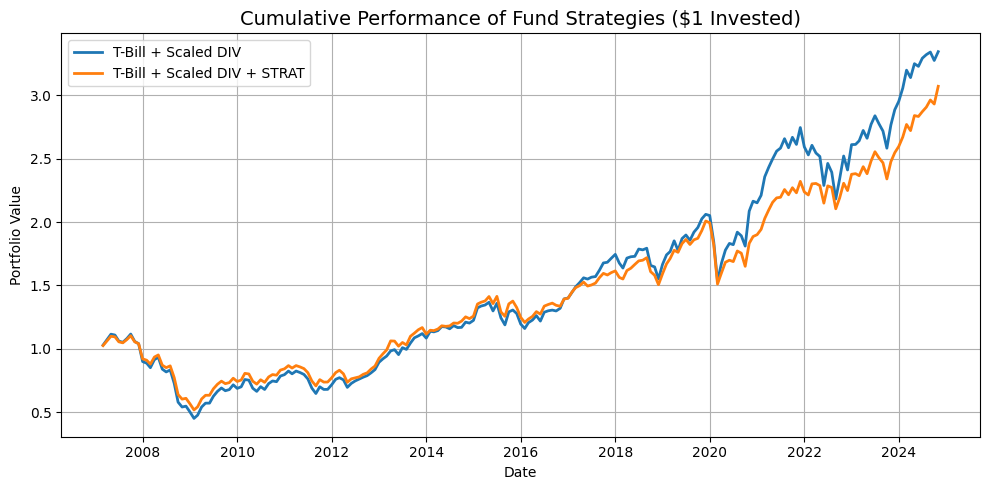


Performance Comparison:


,Strategy,Mean (Annualized),Std Dev (Annualized),Sharpe Ratio
0,T-Bill + Scaled DIV,0.082810,0.169315,0.416478
1,T-Bill + Scaled DIV + STRAT,0.074281,0.146212,0.423952


In [52]:
# Ensure aligned time series
common_dates_84 = R_fund.index.intersection(R_fund_opt.index)
R_fund_84 = R_fund.reindex(common_dates_84)
R_fund_opt_84 = R_fund_opt.reindex(common_dates_84)

# Compute cumulative returns (value of $1 invested)
cumulative_fund = (1 + R_fund_84).cumprod()
cumulative_opt = (1 + R_fund_opt_84).cumprod()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cumulative_fund, label='T-Bill + Scaled DIV', linewidth=2)
plt.plot(cumulative_opt, label='T-Bill + Scaled DIV + STRAT', linewidth=2)
plt.title('Cumulative Performance of Fund Strategies ($1 Invested)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Performance Summary Table ---

def compute_summary(returns, rf_series, name):
    mean_ann = returns.mean() * 12
    std_ann = returns.std() * np.sqrt(12)
    sharpe = (mean_ann - rf_series.mean() * 12) / std_ann
    return {
        'Strategy': name,
        'Mean (Annualized)': mean_ann,
        'Std Dev (Annualized)': std_ann,
        'Sharpe Ratio': sharpe
    }

# Compute summaries
summary_baseline = compute_summary(R_fund_84, rf.loc[R_fund_84.index], 'T-Bill + Scaled DIV')
summary_optimized = compute_summary(R_fund_opt_84, rf.loc[R_fund_opt_84.index], 'T-Bill + Scaled DIV + STRAT')

# Display side-by-side
comparison_summary = pd.DataFrame([summary_baseline, summary_optimized])
print("\nPerformance Comparison:")
display(comparison_summary)


# 9.1

In [53]:
# Load Fama-French 5-factor data
ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)
ff = ff.rename(columns={ff.columns[0]: 'date'})
ff = ff[ff['date'].str.len() == 6]  # Keep only date rows like '200204'
ff = ff[~ff['date'].str.contains('Annual')]  # Remove annual summary if any

# Convert date to datetime
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m')
ff = ff.set_index('date')

# Keep only first 5 columns (ignoring RF if it’s not needed)
ff = ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].astype(float)
ff = ff / 100  # Convert from percentage to decimal

# Align your strategy with FF dates
R_fund_opt = R_fund_opt.reindex(ff.index).dropna()
rf_ff = ff['RF'].reindex(R_fund_opt.index)

# Calculate excess returns
excess_fund = R_fund_opt - rf_ff

# Prepare X and y for regression
X = ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].loc[excess_fund.index]
y = excess_fund

# Add intercept and run regression
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     138.5
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.95e-64
Time:                        05:23:37   Log-Likelihood:                 528.67
No. Observations:                 213   AIC:                            -1045.
Df Residuals:                     207   BIC:                            -1025.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -0.842      0.4